# Classification

**Following code from book - Hands-on Machine Learning with Scikit Learn, Keras, and TensorFlow** <br>
**Author - Aurélien Géron**
Link to book - https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ 

We'll be using MNIST dataset, which is a set of 70,000 small images of digital handwritten by high school students and employees of the US Census Bureau.

This dataset is called the **"Hello World"** of Machine Learning.

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- DESCR key describing the dataset
- data key containing an array with one row per instamce and one column per feature
- target key containing an array with labels

In [2]:
X,y = mnist['data'], mnist['target']

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
X.loc[0]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

There are 70,000 images and each image have 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel;s intensity, from 0 to 255(black).

Let's look at one of the digit. We mneed to grab an instance's feature vector, reshape it to 28x28 array and display using Matplotlib's `imshow()` function.

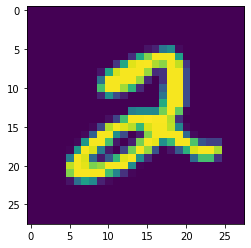

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.loc[5] #any random digit
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image)
plt.show()

This looks like number 2

let's check the target for this.

In [6]:
y[5]

'2'

Note that the label is a string. We prefer numbers. So, let's cast y to integres

In [7]:
import numpy as np

y = y.astype(np.uint8)

Let's split the data before inspecting anything.

In [8]:
X_train, X_test , y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's simplify the problem and just try to identify one digit - number 2. This 2 detector is an example of binary classifier. So, it will give output "num 2" or "not num 2"

In [9]:
y_train_2 = (y_train == 2) #True for all 2s, False for other digits
y_test_2 = (y_test ==2)

We'll use **Stochastic Gradient Descent (SGD)** classifer, using scikit learn's `SGDClassifier` class. This classifier has the advantage of being capable of handling large datasets efficiently.

In [10]:
from sklearn.linear_model import SGDClassifier

#SGDClassifier relies on randomness during training hence the name stochastic
#randomseed for reproducible results
np.random.seed(42)
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_2)

SGDClassifier()

In [11]:
#predicting
sgd_clf.predict([some_digit])

array([ True])

## Performance Measure

### Measuring Accuracy Using Cross-validation

1. Let's implement cross validation without `cross_val_score`
    - The `StratifiedKFold` class performs stratified sampling to produce folds that contains a representative ration of each class. At each iteration the code creates a clone of the classifier, train that clone on the training folds, and make prediction on the test fold. Then it counts the number of correct predictions and outputs tha ratio of correct predictions.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_2):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_2[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_2[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_preds = clone_clf.predict(X_test_fold)
    n_correct = sum(y_preds == y_test_fold)
    print(n_correct/len(y_preds))

0.96005
0.9749
0.97335


2. Using `cross_val_score()` function

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_2, 
                cv=3, 
                scoring="accuracy")

array([0.97225, 0.97345, 0.97255])

This accuracy is amazing 95% But let's just look at our data first

In [14]:
y_train_2.value_counts()

False    54042
True      5958
Name: class, dtype: int64

In [15]:
y_train_2.value_counts(normalize = True)

False    0.9007
True     0.0993
Name: class, dtype: float64

So, we have about 10% of the images that are 2s, so if you always guess that an image is not a 2, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets.

### Confusion Matrix

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_2, cv=3)

Just like `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the prediction made on each test fold.


In [17]:
#this is with cross validation prediction
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_2, y_train_pred)

array([[53278,   764],
       [ 1110,  4848]])

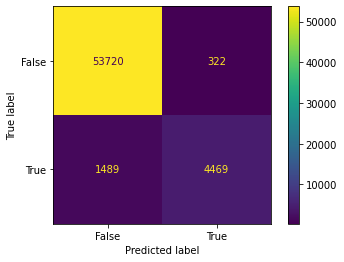

In [18]:
#confusion matrix with our normal selection with training data
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(sgd_clf, X_train, y_train_2)

We can make predictions on test set as well but let's keep that untouched for now. We want to use test data at the very end of the project.

#### Precision - Accuracy of the positive predictions

precision = TP/(TP+FP)

#### Recall - Sensitivity or True positive rate

recall = TP/(TP+FN)

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_2, y_train_pred) #using cross_val_predictions

0.8638631503920171

In [20]:
recall_score(y_train_2, y_train_pred) # using cross_val_predictions

0.8136958710976838

Now our 2-detector does not look that good. When it claims an image represents a 2, it is correct only 77.7% of the time. Moreover, it only detects 87.48% of the 2s.

### F1 Score

It is often good to combine both into f1 score. It is harmonic mean of precision and recall. Where the regular mean treats all values equally, harmonic mean gives much more weight. to low values. So, f1 score will be high only if both precision and recall are high.

f1 = (2*(precision * recall))/(precision + recall)

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_2, y_train_pred)

0.8380293863439932

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall and vice versa. This is called the **precision/recall tradeoff.**

#### Drawing Precision Recall Curve

We'll need scores of all instances in the training set using the `cross_val_predict()` function, but this time specifying that we want it to return decision score instead of predictions.

**Decision Score** is some kind of score that it uses to make predictions. For each instance, it computes a score and if the score is greater than threshold, it assigns the instance to positive class, or else it assigns it to negative class.

Scikit-Learn does not let us set the threshold directly, but it gives us access to **decision scores** that it uses to make predictions. This can be done by calling `decision_function()` method instead of `predict()` method.

In [22]:
y_score = sgd_clf.decision_function([some_digit])

In [23]:
y_score

array([4616.86417714])

I cannot directly change the threshold, but I can do something else. I can manually put threshold value and do predictions.

In [24]:
threshold = 0
y_some_digit_pred = (y_score > threshold)

In [25]:
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred

array([False])

This is how I can change threshold as per my need. So, when my threshold was 0, it predicted True, which is correct. But when I increased the threshold to 8000, it predicted False, which is not correct. But now, we know how to adjust threshold.

#### Decide which threshold to use?

First getting scores of all instances

with those scores we can computer precision and recall for all possible thresholds using `precision_recall_curve()` function.

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv =3,
                             method = 'decision_function') #this will give us decision score instead of predictions

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label ="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] #highlight the threshold, add the legend, axis label and grid

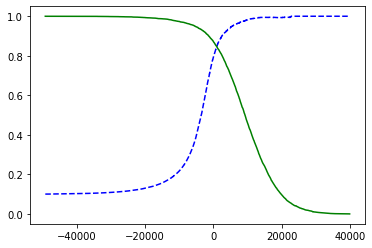

In [32]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

Text(0, 0.5, 'Precision')

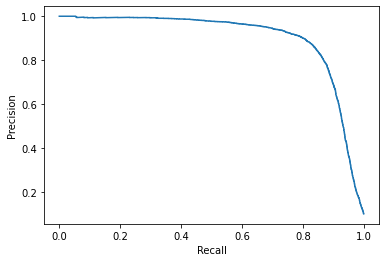

In [34]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")

We can see that precision really starts to fall sharply around 80% recall. We'll probably want to select a precision/recall tradeoff just before that drop, maybe around 60% recall. But it all depends on your project.

Let's suppose we decide to aim for 90% precision. We can look up the first plot and find that threshold. But to be precise, we can search for the lowest threshold that gives us at least 90% precision (`np.argmax()` will give us the first index of the maximum value, which in this case means the first True value)

In [35]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

2500.398172030182

To make predictions, instead of calling the classifier's `predict()` method, we can just run below code. We'll use trainings set, we want to keep test set for later use.

In [36]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [37]:
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [38]:
#checking precision score
precision_score(y_train_2, y_train_pred_90)

0.9000565717518386

In [40]:
#checking recall score
recall_score(y_train_2, y_train_pred_90)

0.8011077542799597

##### THIS IS AMAZING!!

Now we can create a classifier with any precision we want but a high precision classifier is not very useful if its recall is too low!

**If someone says "let's reach 99% precision", you should ask, "at what recall?"**

## ROC - Curve

The Receiver operating characyeristic (ROC) curve is another common tool used with binary classifiers. It is very similar to precision/recall, but it plots the **true positive rate (another name for recall)** against the **false positive rate**. 

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

In [46]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0,1],[0,1], 'k--') #dashed diagnol
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()
    [...] #add axis labels and grid

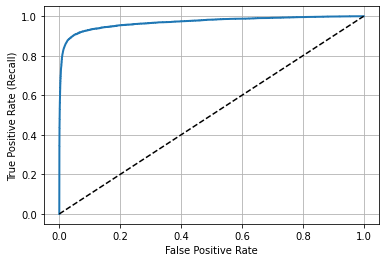

In [47]:
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as away from that line as possible (towards the top-left corner)

One way to produce compare classifiers is to measure the area under the curve (AUC). A perfect classifer will have a ROC AUC equal to 1, whereas a purely random classifer will have a ROC AUC equal to 0.5

we can use `roc_auc_score`

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_2, y_scores)

0.969541092944022

**Note**

Since the ROC curve is so similar to the precision/recall curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the precision/recall curve whenever positive class is rare or when you care more about the false positive than the false negatives, and the ROC curve otherwise.

### Training a RandomForestClassifier and comparing it with SGDClassifier

RandomForestClassifer does not have decision_function() method. Instead it has a `predict_proba()` method . It returns an array containing a row per instance and a column per class, each containing probability that the given instance belongs to the given class (eg 70% chance that the image represents a 2)

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3,
                                    method="predict_proba")

In [50]:
y_probas_forest

array([[1.  , 0.  ],
       [1.  , 0.  ],
       [0.98, 0.02],
       ...,
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.99, 0.01]])

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class's probability as the score

In [51]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2, y_scores_forest)

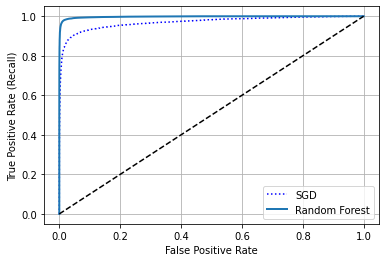

In [52]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [53]:
roc_auc_score(y_train_2, y_scores_forest)

0.9976087190102003

# Multiclass Classification

These algorithms can handle multiclass
- Random Forest Classifier
- Naive Bayes Classifier

While the below one are strictly binary classifiers
- Support Vector Machine classifier
- Linear classifier

However there are ways to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (0-detector, 1-detector, 2-detector, so on) This is called **one-versus-all (OvA) method**

Another strategy is to train a binary classifier for each pair of digits: one to distinguist 0s and 1s, another to distinguish 0s and 2s, and so on. This is called **one-versus-one (OvO) method** for N classes you need N*(N-1) / 2 classifiers. 

Some algorithms (such as SVM classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training a few classifiers on large training set.

For many binary classification problems, however OvA is preferred.

Scikit learn detects when you try to use a binary classification algorithm for multi-class classification task, and it automatically runs OvA (except for SVM classifier which it uses OvO). Let's try this

In [58]:
sgd_clf.fit(X_train,y_train) #not y_train_2 because we are doing multiclass
sgd_clf.predict([some_digit])

array([2], dtype=uint8)

This is easy. Under the hood Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score. We can check the `decision_function()` . This will return 10 scores instead of 1.

In [59]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-16662.66480684, -31922.12773779,   5868.10396885,
         -8894.76692851, -13268.96104982,  -8098.048966  ,
        -16029.3813198 , -25115.34993579,  -6854.98302622,
          -529.24629135]])

In [67]:
for x in range(10):
    print(f"For {x} decision score is {some_digit_scores[0,x]} ")

For 0 decision score is -16662.664806836012 
For 1 decision score is -31922.127737794606 
For 2 decision score is 5868.1039688544515 
For 3 decision score is -8894.766928508538 
For 4 decision score is -13268.961049817997 
For 5 decision score is -8098.048965995969 
For 6 decision score is -16029.38131979697 
For 7 decision score is -25115.349935788407 
For 8 decision score is -6854.983026223796 
For 9 decision score is -529.2462913475715 


These are the scores of 10 different binary classifiers that scikit-learn trained in the backend. We can see that for 2 it has a positive score, rest all are negative, hence it predicted 2. 

In [68]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value. In this case, the each index class in `classes_` conveniently matches the class itself, but in general we won't be this lucky. Hence always check.

If we want to force Scikit-Learn to use one-versus-one or one-versus-all, we can do it using `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a binary classifier to its constructor.

In [69]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([2], dtype=uint8)

In [70]:
len(ovo_clf.estimators_)

45

In [71]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

array([2], dtype=uint8)

This time Scikit-Learn did not have to run OvO or OvA because RandomForestClassifier can directly classify instances into multiple classes. 

We can still call `predict_proba()` to get the list of probabilities that the classifer assigned to each instance for each class.

In [72]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.  , 0.88, 0.01, 0.  , 0.04, 0.01, 0.  , 0.03, 0.02]])

We can see that it is 0.88 sure about class at index 2

**Evaluate these models**

In [73]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85195, 0.89105, 0.8615 ])

In [74]:
# we can improve model by scaling inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89735, 0.89615, 0.90355])

## Error Analysis

**Confusion Matrix**

In [75]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/yogeshtak/Documents/Python3/datascience_env/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5587,    0,   21,    6,    9,   46,   35,    6,  212,    1],
       [   0, 6402,   38,   23,    4,   46,    4,    8,  205,   12],
       [  28,   27, 5237,   96,   73,   28,   66,   37,  356,   10],
       [  23,   17,  117, 5238,    2,  219,   26,   42,  377,   70],
       [  12,   14,   45,   13, 5214,   12,   34,   26,  306,  166],
       [  28,   15,   31,  172,   54, 4493,   72,   16,  483,   57],
       [  28,   15,   44,    2,   43,   98, 5554,    6,  127,    1],
       [  20,    8,   53,   26,   51,   14,    3, 5718,  167,  205],
       [  19,   60,   44,   91,    3,  131,   25,   11, 5422,   45],
       [  24,   18,   29,   64,  117,   40,    1,  181,  341, 5134]])

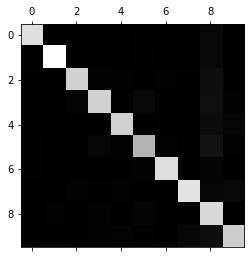

In [76]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This looks fairly good. But let's focus on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute errors (which would make abundant classes look unfairly bad)

In [77]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

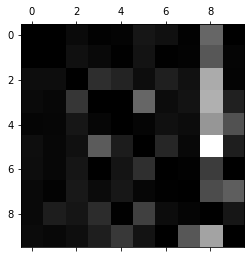

In [78]:
#filling diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

Now you can clearly see the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The column for 8 is quite bright, which tells you that many images get misclassified as 8s. However row 8 is not that bad, which tells us that actual 8s in general gets properly classified. We can see 3s and 5s also often get confused. 

We need to work on reducing the false 8s. Maybe gather more data for digits that look like 8s (but are not) so that classifier can learn to distinguish them from real 8s. Or we could engineer new features that would help classifier.

-for example: **Writing an algorithm to count the number of closed loops (eg, 8 has two, 6 has one, 5 has none).** or you could preprocess the images (using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analysing individual errors can also be a goodway to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time consuimg. Let's do it with 3s and 5s.

In [85]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [np.array(instances.iloc[i]).reshape(size, size) for i in range(instances.shape[0])] #change done here
    
    if images_per_row == 0:
        images_per_row = 0.1
    
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

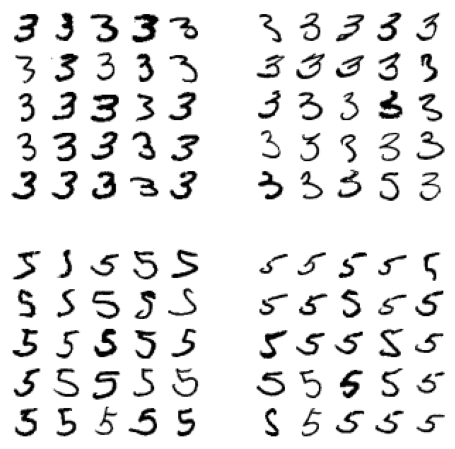

In [90]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row =5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row =5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row =5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row =5)
plt.show()